In [64]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy
import warnings 
warnings.filterwarnings('ignore')

# Monte Carlo, importance sampling, particle filtry

## Importance sampling

Rejection sampling "kompenzuje" fakt, že ke vzorkování používá jinou hustotu, prostřednictvím **přijímání či zahazování** vzorků, což může být vnímáno jako ústupek na efektivitě. Zejména v oblastech, kde je extrémně velký rozdíl mezi mezí $M$ resp. $m(x)$ - např. na chvostech normálního rozdělení - je přijetí vzorku velmi nepravděpodobné. Alternativní metoda - **importance sampling** - tento fakt kompenzuje přidělováním **vah** *všem* vzorkům. 

Označíme-li opět $f(x)$ naši cílovou (komplikovanou) hustotu a $g(x)$ proposal hustotu, zcela přímočaře vidíme, že

$$
\int f(x) dx = \int g(x) \underbrace{\frac{f(x)}{g(x)}}_{= w(x)} dx = \int g(x) w(x) dx.
$$

Podmínkou je, že $g(x) > 0$ všude, kde je $f(x) > 0$.

> **Výpočet vah je triviální: prostě vložíme hodnotu $x$ do známých funkcí $f()$ a $g()$.**

To můžeme navíc pěkně zobecnit, např. pro střední hodnotu $\mathbb{E}[x]$ při $f(x)$ platí

$$
\begin{aligned}
\mathbb{E}_f[x] &= \int x\cdot f(x) dx =  \int x\cdot \frac{f(x)}{g(x)}g(x) dx 
= \int x\cdot w(x) g(x) dx = \mathbb{E}_g[x\cdot w(x)],
\end{aligned}
$$

s podmínkou, že $g(x) > 0$ všude, kde je $x f(x) \ne 0$.

### Počítání s Monte Carlo vzorky

Uvažujme nyní vzorkování $x_1, \ldots, x_N \sim g()$. Potom s $N\to\infty$

$$
\begin{aligned}
\frac{1}{N} \sum_{i=1}^N x_i \cdot w(x_i) 
&\to \mathbb{E}_g[x\cdot w(x)] \\
&\to \mathbb{E}_f[x].
\end{aligned}
$$

Jinými slovy, odhad střední hodnoty dostaneme jako **vážený průměr** vzorků,

$$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i \cdot w(x_i).
$$

#### Normované váhy

Z poslední rovnice výše vidíme, že váhy nejsou normované a nesčítají se do jedné. Normování zde zastupuje faktor $1/N$ a mohli bychom tedy uvažovat

$$
w'(x_i) = \frac{w(x_i)}{N} \qquad\text{kde}\qquad \sum_{i=1}^N w'(x_i) \ne 1.
$$

Často se proto z praktických důvodů používá **normovaná varianta vah**,

$$
W(x_i) = \frac{w(x_i)}{\sum_{i=1}^{N} w(x_i)}.
$$

a odhad střední hodnoty potom je **váženým průměrem** v podobě

$$
\hat{\mu} = \sum_{i=1}^N x_i \cdot W(x_i).
$$

Lze ukázat, že tento odhad je sice vychýlený, ale může mít nižší varianci. V bayesovství má ještě jednu výhodu - nezávisí na normalizační konstantě. A tu, jak víme, počítáme jen neradi :-)

### Příklad: odhad střední hodnoty $\mathcal{U}(0, 5)$
- ze známé formulky $E[x] = \frac{a+b}{2}$,
- přímo ze vzorků z distribuce $\mathcal{U}(0, 5)$
- IS s proposalem $\mathcal{N}(m, s^2)$
   - s vahami $w(x_i)/N$
   - s vahami $w(x_i)/\sum w(x_i)$

U(0, 5):
Skutečné E[x]: 2.5
Odhad z 150 vzorků: 2.44
IS varianta 1: 2.00
IS varianta 2: 2.10


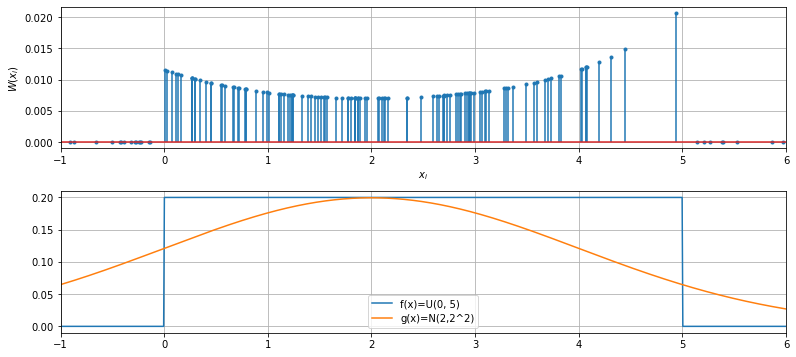

In [81]:
nsamples = 150
a, b = 0, 5
m, s = 2, 2
x = uniform.rvs(a, b, size=nsamples)
mean = uniform.mean(a, b)
print(f"U(0, 5):\nSkutečné E[x]: {uniform.mean(a,b)}")
print(f"Odhad z {nsamples} vzorků: {x.mean():.2f}")

# Importance sampling
samples_from_g = norm.rvs(loc=m, scale=s, size=nsamples)
w_x = uniform.pdf(samples_from_g, a, b) 
w_x /= norm.pdf(samples_from_g, loc=m, scale=s)
mean_is1 = np.mean(samples_from_g * w_x)
W_x = w_x / w_x.sum()
mean_is2 = np.sum(samples_from_g * W_x)
print(f"IS varianta 1: {mean_is1:.2f}")
print(f"IS varianta 2: {mean_is2:.2f}")
plt.figure(figsize=(13,6))
plt.subplot(2,1,1)
plt.xlim((-1, 6))
plt.stem(samples_from_g, W_x, markerfmt='.')
plt.ylabel(r'$W(x_i)$')
plt.xlabel(r'$x_i$')
plt.subplot(2,1,2)
xticks = np.linspace(-1, 6, 1000)
plt.plot(xticks, uniform.pdf(xticks, a, b), label=f'f(x)=U({a}, {b})')
plt.plot(xticks, norm.pdf(xticks, m, s), label=f'g(x)=N({m},{s}^2)')
plt.xlim((-1, 6))
plt.legend()
plt.show()

### Algoritmus IS

Celý algoritmus je o určování vah, které pak používáme např. při výpočtu integrálů.

   1. Nagenerujeme $N$ vzorků z proposal hustoty: $x_i \sim g(x)$.
   2. Spočteme hodnotu hustoty $f(x_i)$.
   3. Spočteme hodnotu hustoty $g(x_i)$.
   4. Spočteme váhy $w(x_i) = \frac{f(x_i)}{g(x_i)}$.
   5. Váhy normalizujeme, buď $W(x_i) = w(x_i)/\sum w(x_i)$ nebo $w'(x_i)=w(x_i)/N$.
   
Např. odhad střední hodnoty $\hat{\mu} = \sum W(x_i) x_i$.

## Empirická distribuce
Empirická distribuce umožňuje aproximovat skutečnou distribuci pomocí vážených či nevážených vzorků. Například histogram je vlastně hrubým zobrazením empirické distribuce - shrne nám vzorky (měření, data) do přihrádek. Zásadním bodem pochopení empirické distribuce je reprezentace bodu ;)

### Nejprve úvod
Představme si směs dvou gaussovek, jejíž hustotu budeme popisovat následovně:

$$
f(x) = w_1 \mathcal{N}(\mu_1, \sigma_1^2) + w_2 \mathcal{N}(\mu_2, \sigma_2^2), \qquad w_1 + w_2 = 1.
$$

Podívejte se na graf výsledné hustoty níže (levý obrázek). A přemýšlejte, když $\sigma_1,\sigma_2\to 0$, a tedy příslušné distribuce zdegenerují do dvou bodů, jak to reprezentovat. Mohli bychom napsat následující?

$$
f(x) = w_1 \mu_1 + w_2 \mu_2, \qquad w_1 + w_2 = 1.
$$

Nemohli! Viz opět obrázek - hustota $f(x)$ by přeci nemohla být jedno číslo, navíc kdesi mezi oběma komponentami! Potřebujeme **bod vhodně reprezentovat** a tou reprezentací je [**Diracova delta distribuce**](https://en.wikipedia.org/wiki/Dirac_delta_function),

$$
f(x) = w_1 \delta_{\mu_1}(x) + w_2 \delta_{\mu_2}(x), \qquad w_1 + w_2 = 1.
$$

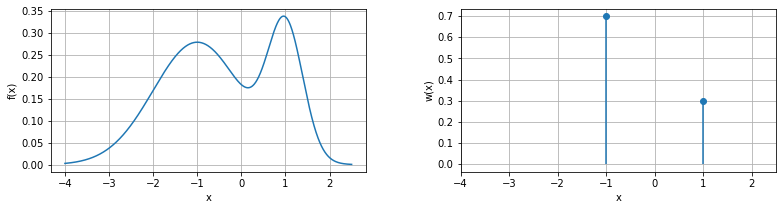

In [63]:
w1, m1, s1 = 0.7, -1, 1
w2, m2, s2 = 0.3, 1, .4

xticks = np.linspace(-4, 2.5, 1000)
plt.figure(figsize=(13,3))
plt.subplot(1, 2, 1)
fx = w1 * norm.pdf(xticks, m1, s1) + w2 * norm.pdf(xticks, m2, s2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(xticks, fx)
plt.subplot(1, 2, 2)
plt.stem([m1, m2], [w1, w2], basefmt=" ")
plt.xlim((-4, 2.5))
plt.xlabel('x')
plt.ylabel('w(x)')
plt.show()

### Zavedení emp. distribuce

Pokud máme vzorky (realizace) $\{x_i\}_{i=1}^N = \{x_1, \ldots, x_N\}$ na množině $E$, můžeme mluvit o empirické distribuci ve tvaru

$$
\eta^N(x) = \frac{1}{N} \sum_{i=1}^N \delta_{x_i}(x).
$$

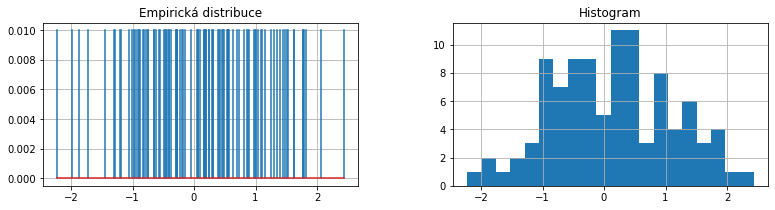

In [11]:
x = np.random.normal(size=100)
plt.figure(figsize=(13,3))
plt.subplot(121)
plt.title('Empirická distribuce')
plt.stem(x, np.ones_like(x)/x.size, markerfmt=' ')
plt.subplot(122)
plt.title('Histogram')
plt.hist(x, bins=20)
plt.show()

Pokud jsou k $x_i$ přiřazeny váhy (např. z importance samplingu), tj. máme dvojice $\{x_i, w_i\}_{i=1}^N$, můžeme mluvit o empirické distribuci ve tvaru

$$
\tilde{\eta}^N(x) = \frac{\sum_{i=1}^N w_i \delta_{x_i}(x)}{\sum_{i=1}^N w_i},
$$

přičemž můžeme normalizaci (viz jmenovatel) provést rovnou,

$$
W_i = \frac{w_i}{\sum_{i=1}^N w_i}
$$

podobně jako v importance samplingu výše. Pak lze psát např.

$$
\int x g(x)dx \approx \int x g^N(x) dx,
$$

kde $g^N(x)$ je empirická distribuce ze vzorků $x_i \sim g(x)$.

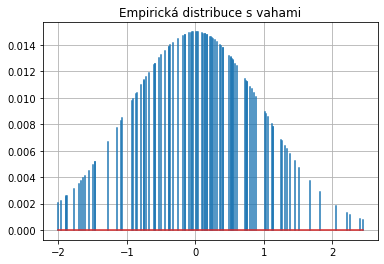

In [12]:
x = norm.rvs(size=100)
wx = norm.pdf(x)
wx /= wx.sum()
plt.stem(x, wx, markerfmt=' ')
plt.title('Empirická distribuce s vahami')
plt.show()

## Sequential Importance Sampling (SIS)

SIS je algoritmus sekvenčního odhadování (typicky stavových modelů) založený na následující myšlence: 
- chceme odhadovat pomocí vzorků $x_t^{(i)}$ ze stavového prostoru $x_t$ s vahami $w_i$
- váhy chceme updatovat tak, aby pravděpodobnějším hodnotám stavové veličiny rostly a těm méně pravděpodobnějším naopak klesaly.

Vraťme se nyní k problematice stavových modelů ve tvaru

$$
\begin{aligned}
x_t &\sim f_t(x_t|x_{t-1}), \\
y_t &\sim g_t(y_t|x_t),
\end{aligned}
$$

kde $x_t$ je nepozorovatelný stav systému, $f_t(x_t|x_{t-1})$ je model vývoje v podobě nějaké vhodné hustoty pravděpodobnosti, $y_t$ jsou pozorování (též měření) a $g_t(y_t|x_t)$ je model pozorování, rovněž v podobě nějaké vhodné hustoty. Pokud oba modely jsou lineární a příslušné funkce jsou hustoty normálního rozdělení, víme z dřívějších přednášek, že sekvenční odhad pro $t=1, 2, \ldots$ poskytne např. Kalmanův filtr. A když linerita splněna není, můžeme zkusit rozšířený Kalmanův filtr. A pokud je nelinerita silná, je velmi vhodné využít právě **SIS**.

Stejně jako v případě Kalmanova filtru (a všech bayesovských odhadů) začneme od vhodně zvolené apriorní hustoty, kterou zde ale **navzorkujeme** do podoby empirické distribuce reprezentované vzorky $\{x_{1:t-1}^{(i)}, w_{t-1}^{(i)}\}_{i=1}^N$,

$$
\pi(x_{1:t-1}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t-1}^{(i)}}(x_{1:t-1}).
$$

Stejně jako v případě základního Kalmanova filtru poběží základní SIS filtr ve dvou krocích - predikce a update.

### Predikce
Predikce udává časový vývoj stavů z $x_{t-1}$ na $x_t$ podle příslušného modelu. Použijeme tedy apriorní distribuci a přenásobíme ji modelem,

$$
\pi(x_{1:t}|y_{1:t-1}) = \pi(x_{1:t-1}|y_{1:t-1}) \cdot f_t(x_t|x_{t-1}).
$$

V SIS filtru to znamená, že vzorky "proženeme" modelem v podobě samplování z modelu, do něhož vložíme vzorky předchozí,

$$
x_t^{(i)} \sim f_t(x_t|x_{t-1}^{(i)}).
$$

Tím dostaneme novou empirickou distribuci

$$
\pi(x_{1:t}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}).
$$

### Update
Update využije Bayesovu větu - vloží do hustoty stavů nová pozorování (měření). Aplikuje ji na empirickou distribuci z predikce,

$$
\begin{aligned}
\pi(x_{1:t}|y_{1:t})
&\propto \pi(x_{1:t}|y_{1:t-1}) \cdot g_t(y_t|x_t) \\[2mm]
&\approx \frac{\sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}) \cdot g(y_t|x_t^{(i)})}{\sum_{i=1}^N w_{t-1}^{(i)}(x_{1:t}) \cdot g(y_t|x_t^{(i)})} \\[2mm]
&\propto \sum_{i=1}^N w_t^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}),
\end{aligned}
$$

kde

$$
w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})
$$

následované normalizací
$$
w_t^{(i)} \leftarrow \frac{w_t^{(i)}}{\sum_{j=1}^N w_t^{(j)}}.
$$

### Poznámka

Výše uvedený update vede po přidání *resampling* - viz níže - na tzv. *bootstrap particle filter*. Obecnější přístup se opírá, podobně jako v IS, o proposal distribuci $q(x_t|x_{t-1}, y_t)$ a updatuje váhy

$$
w_t^{(i)} \propto w_{t-1}^{(i)} \frac{g(y_t|x_t^{(i)}) f(x_{t}|x_{t-1})}{q(x_{t}|x_{t-1}, y_t)}.
$$

Uvedenou variantu dostaneme pokud za proposal použijeme model stavů,

$$
q(x_{t}|x_{t-1}, y_t) \equiv f(x_t|x_{t-1}).
$$

To s sebou nese značné zjednodušení výpočtů, ovšem existují mnohem lepší proposal distribuce.

### Algoritmus SIS filtru
   1. Navzorkujeme $x_0^{(i)}$ z vhodné apriorní distribuce $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. Pro $t=1,2,\ldots$:
       - Predikce: navzorkujeme nová $x_t^{(i)}$ z hustoty $f_t(x_t|x_{t-1}^{(i)})$.
       - Update: přepočítáme váhy $w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})$ a normalizujeme je $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Odhad střední hodnoty $\mathbb{E}[x_t|\cdot] = \sum_{i=1}^{N}w_{t}^{(i)} x_t^{(i)}$.

### Příklad

Uvažujme pro jednoduchost lineární model

$$
\begin{align}
x_t &= 0.9 x_{t-1} + 0.7 + w_t \\
y_t &= 0.5 x_t + v_t
\end{align}
$$

kde $x_1$ = 1 a

$$
w_t \sim \mathcal{N}(0, 0.2^2), \qquad v_t \sim \mathcal{N}(0, 0.2^2).
$$

Jako proposal distribuci použijeme $\mathcal{N}(0, 1)$.

Velmi jednoduchý nepříliš optimální kód může vypadat takto:

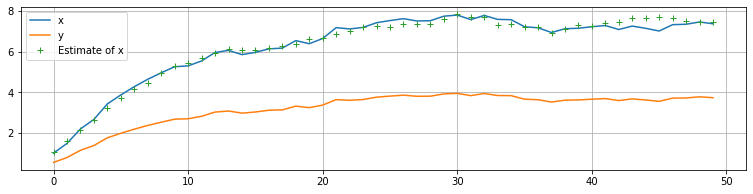

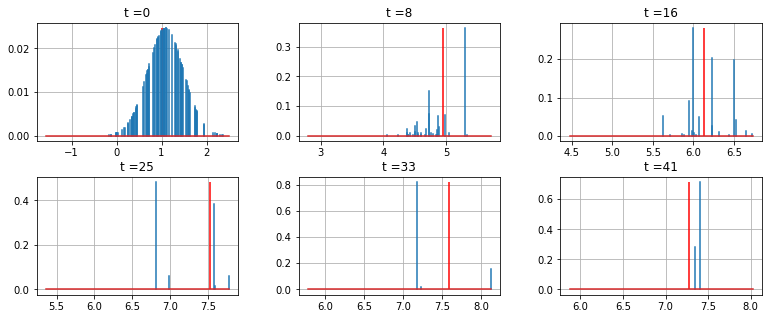

In [13]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

V obrázcích výše vidíme několik zajímavostí. Jednak vývoj stavu $x_t$, jeho odhadu a vývoj pozorování $y_t$. Na 6 malých obrázcích potom vývoj vah pro různé vzorky. Připomeňme, že vzorků je `nsamples`, ale váhy se postupně zkoncentrují na několika málo vzorcích. A co hůř, postupně by celý filtr s rostoucím $t$ zdegeneroval do jediného vzorku! Jak se tento problém řeší se dozvíme u SIR filtru.

Co by šlo dále vylepšit? Předně, výpočet vah jak je uveden výše není numericky stabilní - inkrementální váhy jsou totiž velmi blízké nule a hrozí, že na numerice se po násobení projeví právě tou nulou. To se elegantně řeší počítáním v logaritmech.

## Sequential importance resampling (SIR) - particle filter

V příkladu výše je patrné, jak váhy degenerují a nakonec by jeden vzorek měl váhu limitně rovnu 1 a ostatní 0. To vede ke kolapsu filtru, neboť update vah je postaven na násobení inkrementální vahou - a co je blízké nule se při násobení moc nezmění.

Jedním z nejpopulárnějších řešení probému degenerace je **resampling**. Ten, zjednodušeně řečeno, vybere úspěšnější vzorky (s vyššími vahami) a zreplikuje je. Naopak vzorky s nižšími vahami jsou s vysokou pravděpodobností zahozeny. 

Nejzákladnější metoda provádní výběr $N$ vzorků s opakováním z množiny $\{x_{t-1}^{(i)}, w_t^{(i)}\}_{i=1}^N$, přičemž pravděpodobnost výběru $x_{t-1}^{(i)}$ je proporcionální k jeho váze $w_{t-1}^{(i)}$. Vzorky s vyššími vahami jsou tedy pravděpodobně vybrány vícekrát a naopak. Jejich rozprostření následně obstará model vývoje. Váhy jsou srovnány na $1/N$ pro všechny vzorky.

### Algoritmus bootstrap particle filtru
   1. Navzorkujeme $x_0^{(i)}$ z vhodné apriorní distribuce $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. Pro $t=1,2,\ldots$:
       - Resampling: vybereme $\tilde{x}_{t-1}^{(i)}\sim \sum_{i=1}^N w_{t-1}^{(i)} x_{t-1}^{(i)}$ proporcionálně k jejich vahám $w_{t-1}^{(i)}$, nastavíme všem vzorkům váhy $1/N$.
       - Predikce: navzorkujeme nová $x_t^{(i)}$ z hustoty $f_t(x_t|\tilde x_{t-1}^{(i)})$.
       - Update: přepočítáme váhy $w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})$ a normalizujeme je $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Odhad střední hodnoty $\mathbb{E}[x_t|\cdot] = \sum_{i=1}^{N}w_{t}^{(i)} x_t^{(i)}$.
       
Jak je patrné, oproti SIS filtru přibyl jediný krok, a sice zmíněný (zde multinomický) resampling. Existuje více možností, jak se k resamplingu postavit:
   - resamplovat každé $t$, nebo jen tehdy, když je to "nějak" výhodnější.
   - využít různé resamplovací algoritmy - stratifikovaný resampling aj.

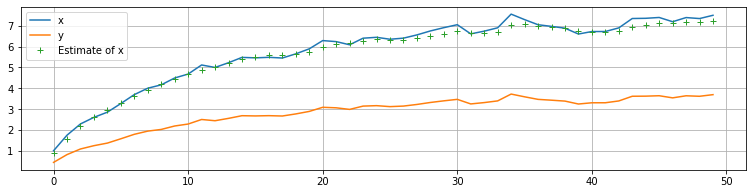

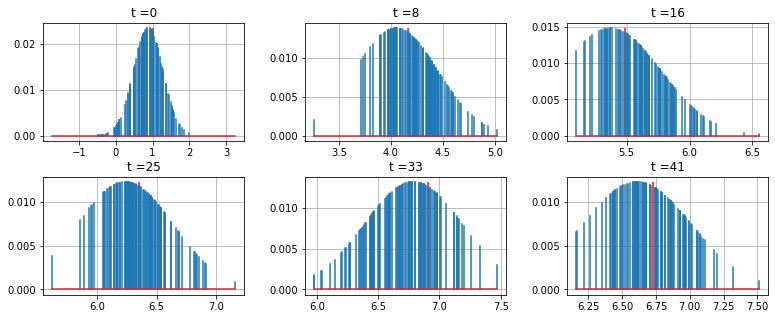

In [15]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

def resample(x, weights):
    xnew = np.random.choice(x, replace=True, p=weights, size=weights.size)
    weights = np.ones_like(weights)/weights.size
    return [xnew, weights]

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

## Další možnosti particle filtrace

Co můžeme zlepšit na filtraci pomocí vzorků ze stavového prostoru? Z těch základních možností jmenujme hlavně:
   - marginalizované particle filtry - je-li část modelu lineární, lze ji počítat analyticky a zbytek Monte Carlo metodami.
   - Auxiliary particle filter - jiný přístup k PF.
   - Approximate Bayesian filter - pokud model pozorování $g_t$ není hustota pravděpodobnosti, nebo je příliš komplikovaná na výpočet.
   - a spousty dalšího...